 Sample code online for calculating the autocorrelation time 


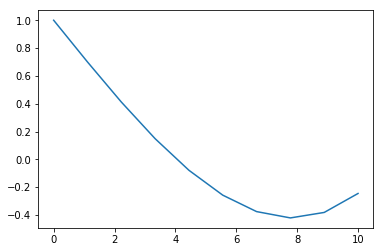

In [12]:
import numpy as np
import matplotlib.pyplot as mp
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf
x=np.linspace(0,10,10)
y=autocorr_func_1d(x)
mp.plot(x,y)

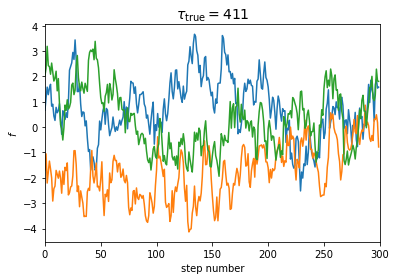

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

# Build the celerite model:
import celerite
from celerite import terms
kernel = terms.RealTerm(log_a=0.0, log_c=-6.0)
kernel += terms.RealTerm(log_a=0.0, log_c=-2.0)
 
# The true autocorrelation time can be calculated analytically:
true_tau = sum(2*np.exp(t.log_a-t.log_c) for t in kernel.terms)
true_tau /= sum(np.exp(t.log_a) for t in kernel.terms)
true_tau

# Simulate a set of chains:
gp = celerite.GP(kernel)
t = np.arange(2000000)
gp.compute(t)
y = gp.sample(size=32)

# Let's plot a little segment with a few samples:
plt.plot(y[:3, :300].T)
plt.xlim(0, 300)
plt.xlabel("step number")
plt.ylabel("$f$")
plt.title("$\\tau_\mathrm{{true}} = {0:.0f}$".format(true_tau), fontsize=14);

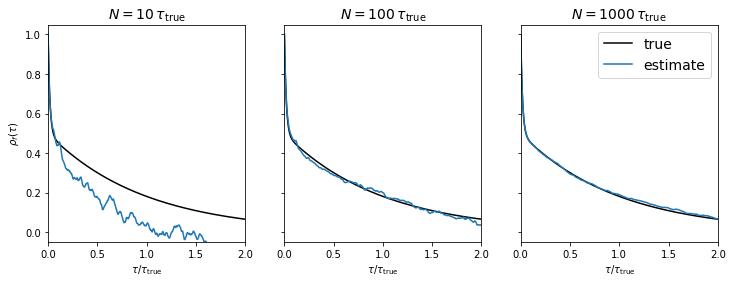

In [14]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Make plots of ACF estimate for a few different chain lengths
window = int(2*true_tau)
tau = np.arange(window+1)
f0 = kernel.get_value(tau) / kernel.get_value(0.0)

# Loop over chain lengths:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    ax.plot(tau / true_tau, autocorr_func_1d(y[0, :nn])[:window+1], label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

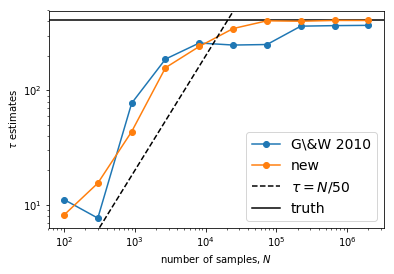

In [15]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);